In [1]:
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy import units as u

import glob
import h5py
import itertools
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(6)
import pandas as pd
from pycm import ConfusionMatrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
import torchvision
import torchvision.models as models
from torchvision import transforms
from scipy import ndimage
from scipy.interpolate import LinearNDInterpolator

In [2]:
def TrainTest(dataset, md, cut, stop, value):
    
    hf = h5py.File(dataset, 'r')
    dataset_name = list(hf.keys())[0]
    images = np.array(hf.get(dataset_name))
    hf.close()
    X_train, X_test = images[0:cut], images[cut:stop]
    md_df = pd.read_csv(md)
    if 'OBJID_COPY' in md_df:
        md_df['OBJID'] = md_df['OBJID_COPY'].values
    md_train, md_test = md_df[0:cut], md_df[cut:stop]
    

    y_train, y_test = np.array([value] * len(X_train)), np.array([value] * len(X_test))
    
    return X_train, X_test, y_train, y_test, md_train, md_test

In [3]:
def gaussian2D(distance_to_center, sigma):
    return 1/(sigma**2*2*np.pi)*np.exp(-0.5*((distance_to_center)/sigma)**2)

In [4]:
def TemplateCenter(images, metadata):
    template_images = images[:,0,:,:]
    psfs = metadata['PSF'].values
    psf_in_px = psfs / 0.263
    psf_in_px = psfs[:,np.newaxis,np.newaxis] / 0.263 / 2.3548
    yy, xx = np.indices(template_images[0].shape)
    center_x, center_y = 25, 25
    distance_to_center = np.sqrt((yy - center_y)**2 + (xx - center_x)**2)[np.newaxis,:]
    distance_to_center = np.vstack(len(template_images)*[distance_to_center])
    psf_weights = gaussian2D(distance_to_center, psf_in_px)
    backgrounds = np.median(template_images, axis=(-1,-2))[:,np.newaxis,np.newaxis]
    center_fluxes = np.sum((template_images - backgrounds) * psf_weights, axis=(-1,-2))
    return center_fluxes

In [5]:
def SNR(metadata):
    metadata['SNR'] = metadata['FLUXCAL'].values/metadata['FLUXCALERR'].values
    return metadata['SNR'].values

In [6]:
def CatalogMatching(images, labels, metadata):
    # read in LightCurvesRealCoords.csv
    snid_coords = pd.read_csv('LightCurvesRealCoords.csv')
    # assume metadata is stored in "md_df"
    md_df = metadata.merge(snid_coords, on='SNID', how='inner')
    # Load in catalog
    catalog_df = pd.read_csv('DES_Star_Catalog_SOF.csv')
    # Use astropy
    catalog_coords = SkyCoord(ra= catalog_df['STAR_RA'].values*u.degree, dec= catalog_df['STAR_DEC'].values * u.degree)
    candidate_coords = SkyCoord(ra= md_df['RA'].values*u.degree, dec= md_df['DEC'].values * u.degree)
    idx, d2d, d3d = match_coordinates_sky(candidate_coords, catalog_coords)
    #https://docs.astropy.org/en/stable/api/astropy.coordinates.match_coordinates_sky.html#astropy.coordinates.match_coordinates_sky
    # filter results
    threshold = 1 # in arcsec
    arc_sec_mask = (d2d > threshold * u.arcsec)
    md_indices = np.arange(len(md_df), dtype=int)
    keep_indices = md_indices[arc_sec_mask]
    md_objects_passing_catalog_match = md_df.loc[keep_indices]
    #apply to images
    return images[keep_indices], labels[keep_indices], md_objects_passing_catalog_match.reset_index(drop=True)

In [7]:
X_train0_0, X_test0_0, y_train0_0, y_test0_0, mdtrain0_0, mdtest0_0 = TrainTest('TS__2020-11-25_19-38-15/Class_0_images.h5','TS__2020-11-25_19-38-15/Class_0_metadata.csv',100,371,0)
X_train0_2, X_test0_2, y_train0_2, y_test0_2, mdtrain0_2, mdtest0_2 = TrainTest('Real__20-07-11_21-31-43/s200224ca_images.h5','Real__20-07-11_21-31-43/s200224ca_metadata.csv',100,214,0)

mdtrain0_2['ACTION'] = ['Good' for i in range(len(mdtrain0_2))]
mdtest0_2['ACTION'] = ['Good' for i in range(len(mdtest0_2))]

X_train0, X_test0 = np.concatenate((X_train0_0,X_train0_2)), np.concatenate((X_test0_0,X_test0_2))
y_train0, y_test0 = np.concatenate((y_train0_0,y_train0_2)), np.concatenate((y_test0_0,y_test0_2))
mdtrain0, mdtest0 = pd.concat([mdtrain0_0,mdtrain0_2]), pd.concat([mdtest0_0,mdtest0_2])
images_0 = np.concatenate((X_train0_0,X_train0_2,X_test0_0,X_test0_2))
y_0 = np.concatenate((y_train0_0, y_train0_2, y_test0_0, y_test0_2))
md_0 = pd.concat([mdtrain0,mdtest0])

X_train1, X_test1, y_train1, y_test1, mdtrain1, mdtest1 = TrainTest('TS__2020-11-25_19-38-15/Class_1_images.h5','TS__2020-11-25_19-38-15/Class_1_metadata.csv',500,1000,0)
images_1 = np.concatenate((X_train1, X_test1))
y_1 = np.concatenate((y_train1, y_test1))
md_1 = pd.concat([mdtrain1, mdtest1])

X_train3, X_test3, y_train3, y_test3, mdtrain3, mdtest3 = TrainTest('TS__2020-11-25_19-38-15/Class_3_images.h5','TS__2020-11-25_19-38-15/Class_3_metadata.csv',450,1450,1)
images_3 = np.concatenate((X_train3, X_test3))
y_3 = np.concatenate((y_train3, y_test3))
md_3 = pd.concat([mdtrain3, mdtest3])

X_train4, X_test4, y_train4, y_test4, mdtrain4, mdtest4 = TrainTest('TS__2020-11-25_19-38-15/Class_4_images.h5','TS__2020-11-25_19-38-15/Class_4_metadata.csv',274,363,0)
images_4 = np.concatenate((X_train4, X_test4))
y_4 = np.concatenate((y_train4, y_test4))
md_4 = pd.concat([mdtrain4, mdtest4])

X_train5, X_test5, y_train5, y_test5, mdtrain5, mdtest5 = TrainTest('TS__2020-11-25_19-38-15/Class_5_images.h5','TS__2020-11-25_19-38-15/Class_5_metadata.csv',274,368,0)
images_5 = np.concatenate((X_train5, X_test5))
y_5 = np.concatenate((y_train5, y_test5))
md_5 = pd.concat([mdtrain5, mdtest5])

X_train6, X_test6, y_train6, y_test6, mdtrain6, mdtest6 = TrainTest('TS__2020-11-25_19-38-15/Class_6_images.h5','TS__2020-11-25_19-38-15/Class_6_metadata.csv',362,1100,0)
images_6 = np.concatenate((X_train6, X_test6))
y_6 = np.concatenate((y_train6, y_test6))
md_6 = pd.concat([mdtrain6, mdtest6])

In [8]:
class0_centers = TemplateCenter(images_0,md_0)
class1_centers = TemplateCenter(images_1,md_1)
class3_centers = TemplateCenter(images_3,md_3)
class4_centers = TemplateCenter(images_4,md_4)
class5_centers = TemplateCenter(images_5,md_5)
class6_centers = TemplateCenter(images_6,md_6)
good_centers = np.concatenate((class0_centers, class1_centers, class3_centers, class6_centers))
notgood_centers = np.concatenate((class4_centers, class5_centers))
md_good = pd.concat([md_0, md_1, md_3, md_6], ignore_index=True)
md_notgood = pd.concat([md_4,md_5], ignore_index=True)
purity_centers, completeness_centers = [], []
thresholds = np.linspace(np.concatenate((good_centers, notgood_centers)).min(), 
                         np.concatenate((good_centers, notgood_centers)).max(), 1000)
for threshold in thresholds:
    tp = np.sum(good_centers > threshold)
    fn = np.sum(good_centers < threshold)
    fp = np.sum(notgood_centers > threshold)
    purity_centers.append(tp / (tp + fp))
    completeness_centers.append(tp / (tp + fn))
desired_completeness = 0.99
center_thres = thresholds[np.argmin(np.abs(np.array(completeness_centers) - desired_completeness))]


thresgood_snr = SNR(md_good.loc[np.where(good_centers > center_thres)[0]])
thresbad_snr = SNR(md_notgood.loc[np.where(notgood_centers > center_thres)[0]])
purity_snr, completeness_snr = [], []
thresholds = np.linspace(np.concatenate((thresbad_snr, thresgood_snr)).min(), 
                         np.concatenate((thresbad_snr, thresgood_snr)).max(), 1000)
for threshold in thresholds:
    tp = np.sum(thresgood_snr > threshold)
    fn = np.sum(thresgood_snr < threshold)
    fp = np.sum(thresbad_snr > threshold)
    purity_snr.append(tp / (tp + fp))
    completeness_snr.append(tp / (tp + fn))
desired_completeness = 0.99
snr_thres = thresholds[np.argmin(np.abs(np.array(completeness_snr) - desired_completeness))]

/home/ashandonay/miniconda3/envs/ml_astro/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/home/ashandonay/miniconda3/envs/ml_astro/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in long_scalars


In [10]:
X_train, X_test = np.concatenate((X_train0,X_train3)), np.concatenate((X_test0,X_test3))
y_train, y_test = np.concatenate((y_train0,y_train3)), np.concatenate((y_test0,y_test3))
md_train, md_test = pd.concat([mdtrain0,mdtrain3], ignore_index=True), pd.concat([mdtest0,mdtest3], ignore_index=True)

In [11]:
train_centers = TemplateCenter(X_train, md_train)
test_centers = TemplateCenter(X_test, md_test)

train_snr = SNR(md_train.loc[np.where(train_centers > center_thres)[0]])
test_snr = SNR(md_test.loc[np.where(test_centers > center_thres)[0]])

md_train_centers = md_train.loc[np.where(train_centers > center_thres)[0]].reset_index(drop=True)
md_test_centers = md_test.loc[np.where(test_centers > center_thres)[0]].reset_index(drop=True)

md_train_filtered = md_train_centers.loc[np.where(train_snr > snr_thres)[0]]
md_test_filtered = md_test_centers.loc[np.where(test_snr > snr_thres)[0]]

train_remaining_indices = md_train[['OBJID']].merge(md_train_filtered, on='OBJID', how='inner', right_index=True).index
test_remaining_indices = md_test[['OBJID']].merge(md_test_filtered, on='OBJID', how='inner', right_index=True).index

X_train = X_train[train_remaining_indices]
X_test = X_test[test_remaining_indices]
y_train = y_train[train_remaining_indices]
y_test = y_test[test_remaining_indices]
md_train = md_train_filtered.reset_index(drop=True)
md_test = md_test_filtered.reset_index(drop=True)

X_train, y_train, md_train = CatalogMatching(X_train, y_train, md_train)
X_test, y_test, md_test = CatalogMatching(X_test, y_test, md_test)

In [12]:
X_train0_sims, X_test0_sims, y_train0_sims, y_test0_sims, mdtrain0_sims, mdtest0_sims = TrainTest('good_simulated_images.h5','good_simulated_metadata.csv',250,500,0)

In [12]:
X_train, X_test = np.concatenate((X_train,X_train0_sims)), np.concatenate((X_test,X_test0_sims))
y_train, y_test = np.concatenate((y_train,y_train0_sims,y_train1,y_train3)), np.concatenate((y_test,y_test0_sims))
md_train, md_test = pd.concat([md_train,mdtrain0_sims], ignore_index=True), pd.concat([md_test,mdtest0_sims], ignore_index=True)

In [13]:
print(len(md_train.loc[md_train['ACTION'] == 'Good']))
print(len(md_train.loc[md_train['ACTION'] == 'Marginal']))
print(len(md_train.loc[md_train['ACTION'] == 'BadSubtraction']))
print(len(md_train.loc[md_train['ACTION'] == 'NoisyTemplate']))
print(len(md_train.loc[md_train['ACTION'] == 'DarkSpotInTemplateCenter']))
print(len(md_train.loc[md_train['ACTION'] == 'PsfInTemplate']))

445
0
434
0
0
0


In [14]:
train_idx = np.arange(X_train.shape[0])
np.random.shuffle(train_idx)
X_train = X_train[train_idx]
y_train = y_train[train_idx]
md_train = md_train.iloc[train_idx].reset_index(drop=True)

test_idx = np.arange(X_test.shape[0])
np.random.shuffle(test_idx)
X_test = X_test[test_idx]
y_test = y_test[test_idx]
md_test = md_test.iloc[test_idx].reset_index(drop=True)

In [15]:
class ArtifactDataset(Dataset):
    """PyTorch Dataset of Artifact Images"""

    def __init__(self, images, labels, metadata, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.metadata = metadata

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]
        label = np.array(self.labels[idx])
        objid = self.metadata.OBJID[idx]
        
        sample = {'image': image, 'label': label, 'objid': objid}

        if self.transform:
            sample = self.transform(sample)

        return sample
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image_, label, objid = sample['image'], sample['label'], sample['objid']

        scaled_array = (image_ - np.mean(image_,axis=(-1,-2),keepdims=True))/(10*np.std(image_,axis=(-1,-2),keepdims=True)) + 0.5
        return {'image': torch.from_numpy(scaled_array).float(),
                'label': torch.from_numpy(label),
                'objid': torch.from_numpy(np.asarray(objid))}

In [16]:
def make_datasets(X_train, y_train, X_test, y_test, md_train, md_test, batch_size=20):
    
    train_dataset = ArtifactDataset(X_train, y_train, md_train, transform=ToTensor())
    test_dataset = ArtifactDataset(X_test, y_test, md_test, transform=ToTensor())
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    return train_dataset, test_dataset, train_dataloader

In [17]:
train_dataset, test_dataset, train_dataloader = make_datasets(X_train, y_train, X_test, y_test, md_train, md_test)

In [18]:
train_size = 100
validation_size = 100
size_train = len(y_train)
size_test = len(y_test)

In [19]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        #Network Components
        self.conv1 = nn.Conv2d(in_channels=3, 
                               out_channels=32, 
                               kernel_size=4, 
                               stride=1,
                               padding=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, 
                               out_channels=64,
                               kernel_size=2, 
                               stride=1,
                               padding=2)

        self.conv3 = nn.Conv2d(in_channels=64, 
                               out_channels=128,
                               kernel_size=2, 
                               stride=1,
                               padding=2)
        
        self.dropout1 = nn.Dropout2d(0.25)
        
        self.dropout2 = nn.Dropout2d(0.5)
        
        self.fc1 = nn.Linear(in_features=107648, 
                             out_features=328)
        
        self.fc2 = nn.Linear(in_features=328, 
                             out_features=18)
        
        self.fc3 = nn.Linear(in_features=18, 
                             out_features=2)
        
    def forward(self, x):
        #Network Flow
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output
    
cnn = CNN()

In [20]:
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
number_of_training_epochs = 15

In [21]:
# Append some lists as we go to track the accuracies and loss
indices, losses, train_acc, validation_acc = [], [], [], []
index_counter = 0


for epoch in range(number_of_training_epochs):
    
    for step, batch_data in enumerate(train_dataloader):
        
        #Clear out all existing gradients on the loss surface to reevaluate for this step
        optimizer.zero_grad()
        
        #Get the CNN's current prediction of the training data
        output = cnn(batch_data['image'])
        
        #Calculate the loss by comparing the prediction to the truth
        loss = loss_function(output, batch_data['label'])
        
        #Evaluate all gradients along the loss surface using back propagation
        loss.backward()
        
        #Based on the gradients, take the optimal step in the weight space
        optimizer.step()
            
        
        #Every so often, let's print out the accuracy
        if step == 0:
            
            #Evaluate the network's predictions
            train_output = cnn(train_dataset[0:train_size]['image'])
            validation_output = cnn(test_dataset[0:validation_size]['image'])
            
            train_predictions = torch.max(train_output, 1)[1].data.numpy()
            validation_predictions = torch.max(validation_output, 1)[1].data.numpy()
            
            #Calculate accuracy
            train_accuracy = np.sum(train_predictions == train_dataset[0:train_size]['label'].numpy()) / train_size
            validation_accuracy = np.sum(validation_predictions == test_dataset[0:validation_size]['label'].numpy()) / validation_size
            
            print("Epoch: {0} Step: {1}  | Training Accuracy: {2} -- Validation Accuracy: {3}".format(epoch + 1, step, train_accuracy, validation_accuracy))
            
            #save results to list for diagnostic plots
            indices.append(index_counter)
            losses.append(loss.data.numpy())
            train_acc.append(train_accuracy)
            validation_acc.append(validation_accuracy)
            index_counter += 1
            
            

Epoch: 1 Step: 0  | Training Accuracy: 0.53 -- Validation Accuracy: 0.56
Epoch: 2 Step: 0  | Training Accuracy: 0.58 -- Validation Accuracy: 0.6
Epoch: 3 Step: 0  | Training Accuracy: 0.79 -- Validation Accuracy: 0.73
Epoch: 4 Step: 0  | Training Accuracy: 0.75 -- Validation Accuracy: 0.8
Epoch: 5 Step: 0  | Training Accuracy: 0.79 -- Validation Accuracy: 0.8
Epoch: 6 Step: 0  | Training Accuracy: 0.91 -- Validation Accuracy: 0.89
Epoch: 7 Step: 0  | Training Accuracy: 0.91 -- Validation Accuracy: 0.91
Epoch: 8 Step: 0  | Training Accuracy: 0.92 -- Validation Accuracy: 0.91
Epoch: 9 Step: 0  | Training Accuracy: 0.89 -- Validation Accuracy: 0.88
Epoch: 10 Step: 0  | Training Accuracy: 0.9 -- Validation Accuracy: 0.94
Epoch: 11 Step: 0  | Training Accuracy: 0.93 -- Validation Accuracy: 0.92
Epoch: 12 Step: 0  | Training Accuracy: 0.94 -- Validation Accuracy: 0.92
Epoch: 13 Step: 0  | Training Accuracy: 0.91 -- Validation Accuracy: 0.9
Epoch: 14 Step: 0  | Training Accuracy: 0.92 -- Vali

In [14]:
X_test = np.concatenate((X_test0,images_1,X_test3,images_4,images_5,images_6))
y_test = np.concatenate((y_test0,y_1,y_test3,y_4,y_5,y_6))
md_test = pd.concat([mdtest0,md_1,mdtest3,md_4,md_5,md_6], ignore_index=True)

In [15]:
test_centers = TemplateCenter(X_test, md_test)

test_snr = SNR(md_test.loc[np.where(test_centers > center_thres)[0]])

md_test_centers = md_test.loc[np.where(test_centers > center_thres)[0]].reset_index(drop=True)

md_test_filtered = md_test_centers.loc[np.where(test_snr > snr_thres)[0]]

test_remaining_indices = md_test[['OBJID']].merge(md_test_filtered, on='OBJID', how='inner', right_index=True).index

X_test = X_test[test_remaining_indices]
y_test = y_test[test_remaining_indices]
md_test = md_test_filtered.reset_index(drop=True)

X_test, y_test, md_test = CatalogMatching(X_test, y_test, md_test)

In [16]:
test_idx = np.arange(X_test.shape[0])
np.random.shuffle(test_idx)
X_test = X_test[test_idx]
y_test = y_test[test_idx]
md_test = md_test.iloc[test_idx].reset_index(drop=True)

In [25]:
test_dataset_full = ArtifactDataset(X_test, y_test, md_test, transform=ToTensor())

In [26]:
validation_probs1 = torch.max(cnn(test_dataset_full[0:1000]['image']), 1)[1].data.numpy()

In [27]:
validation_probs2 = torch.max(cnn(test_dataset_full[1000:2000]['image']), 1)[1].data.numpy()

In [28]:
validation_probs3 = torch.max(cnn(test_dataset_full[2000:3500]['image']), 1)[1].data.numpy()

In [29]:
validation_probs = np.concatenate((validation_probs1, validation_probs2, validation_probs3))
md_test = pd.concat([md_test[0:1000],md_test[1000:2000],md_test[2000:3500]]).reset_index()

pred_class0 = validation_probs[md_test.loc[md_test['ACTION'] == 'Good'].index]
pred_class1 = validation_probs[md_test.loc[md_test['ACTION'] == 'Marginal'].index]
pred_class3 = validation_probs[md_test.loc[md_test['ACTION'] == 'BadSubtraction'].index]
pred_class4 = validation_probs[(md_test.loc[md_test['ACTION'] == 'DarkSpotInTemplateCenter'].index) | 
                                         (md_test.loc[md_test['ACTION'] == 'NoisyTemplate'].index)]
pred_class6 = validation_probs[md_test.loc[md_test['ACTION'] == 'PsfInTemplate'].index]

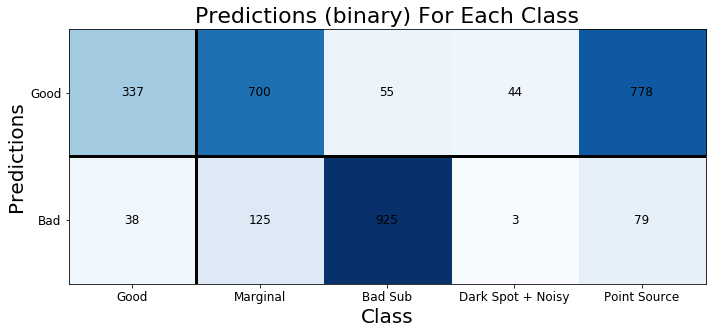

In [30]:
pred0_class0 = (pred_class0 == 0).sum()
pred1_class0 = (pred_class0 == 1).sum()

pred0_class1 = (pred_class1 == 0).sum()
pred1_class1 = (pred_class1 == 1).sum()

pred0_class3 = (pred_class3 == 0).sum()
pred1_class3 = (pred_class3 == 1).sum()

pred0_class4 = (pred_class4 == 0).sum()
pred1_class4 = (pred_class4 == 1).sum()

pred0_class6 = (pred_class6 == 0).sum()
pred1_class6 = (pred_class6 == 1).sum()

cm = np.array([[pred0_class0,pred0_class1,pred0_class3,pred0_class4,pred0_class6],
                [pred1_class0,pred1_class1,pred1_class3,pred1_class4,pred1_class6]])

classes = ['Good','Marginal','Bad Sub','Dark Spot + Noisy','Point Source']
labels = ['Good','Bad']

fig, ax = plt.subplots(1,1,figsize=(10, 8))

ax.imshow(cm, cmap=plt.cm.Blues)
ax.set_xlabel("Class", fontsize=20)
ax.set_ylabel("Predictions", fontsize=20)
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(classes, fontsize=12)
ax.set_yticklabels(labels, fontsize=12)
ax.axhline(0.5, linestyle='-', color='k', linewidth='3')
ax.axvline(0.5, linestyle='-', color='k', linewidth='3')

for i in range(len(labels)):
    for j in range(len(classes)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", fontsize=12)

ax.set_title('Predictions (binary) For Each Class', fontsize=22)
fig.tight_layout()

In [31]:
print(len(md_test.loc[md_test['ACTION'] == 'Good']))
print(len(md_test.loc[md_test['ACTION'] == 'Marginal']))
print(len(md_test.loc[md_test['ACTION'] == 'BadSubtraction']))
print(len(md_test.loc[md_test['ACTION'] == 'NoisyTemplate']))
print(len(md_test.loc[md_test['ACTION'] == 'DarkSpotInTemplateCenter']))
print(len(md_test.loc[md_test['ACTION'] == 'PsfInTemplate']))

375
825
980
36
11
857


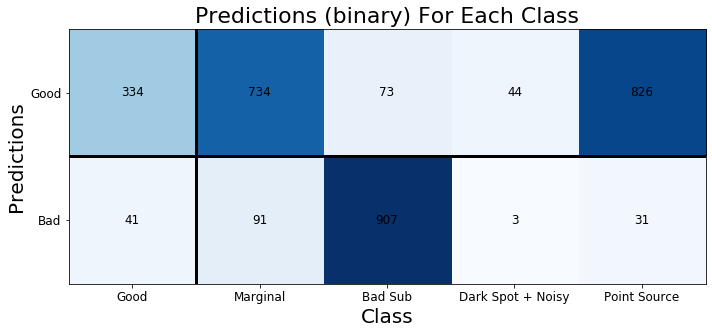

In [32]:
pred0_class0 = (pred_class0 == 0).sum()
pred1_class0 = (pred_class0 == 1).sum()

pred0_class1 = (pred_class1 == 0).sum()
pred1_class1 = (pred_class1 == 1).sum()

pred0_class3 = (pred_class3 == 0).sum()
pred1_class3 = (pred_class3 == 1).sum()

pred0_class4 = (pred_class4 == 0).sum()
pred1_class4 = (pred_class4 == 1).sum()

pred0_class6 = (pred_class6 == 0).sum()
pred1_class6 = (pred_class6 == 1).sum()

cm = np.array([[pred0_class0,pred0_class1,pred0_class3,pred0_class4,pred0_class6],
                [pred1_class0,pred1_class1,pred1_class3,pred1_class4,pred1_class6]])

classes = ['Good','Marginal','Bad Sub','Dark Spot + Noisy','Point Source']
labels = ['Good','Bad']

fig, ax = plt.subplots(1,1,figsize=(10, 8))

ax.imshow(cm, cmap=plt.cm.Blues)
ax.set_xlabel("Class", fontsize=20)
ax.set_ylabel("Predictions", fontsize=20)
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(classes, fontsize=12)
ax.set_yticklabels(labels, fontsize=12)
ax.axhline(0.5, linestyle='-', color='k', linewidth='3')
ax.axvline(0.5, linestyle='-', color='k', linewidth='3')

for i in range(len(labels)):
    for j in range(len(classes)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", fontsize=12)

ax.set_title('Predictions (binary) For Each Class', fontsize=22)
fig.tight_layout()

In [31]:
validation_probs1 = cnn(test_dataset_full[0:1000]['image']).data.numpy()

In [32]:
validation_probs2 = cnn(test_dataset_full[1000:2000]['image']).data.numpy()

In [33]:
validation_probs3 = cnn(test_dataset_full[2000:3500]['image']).data.numpy()

In [34]:
validation_probs = np.concatenate((validation_probs1, validation_probs2, validation_probs3))
md_test = pd.concat([md_test[0:1000],md_test[1000:2000],md_test[2000:3500]]).reset_index(drop=True)

validation_probs -= validation_probs.min()
validation_probs /= validation_probs.max()
validation_probs /= np.sum(validation_probs, axis=1)[:,np.newaxis]

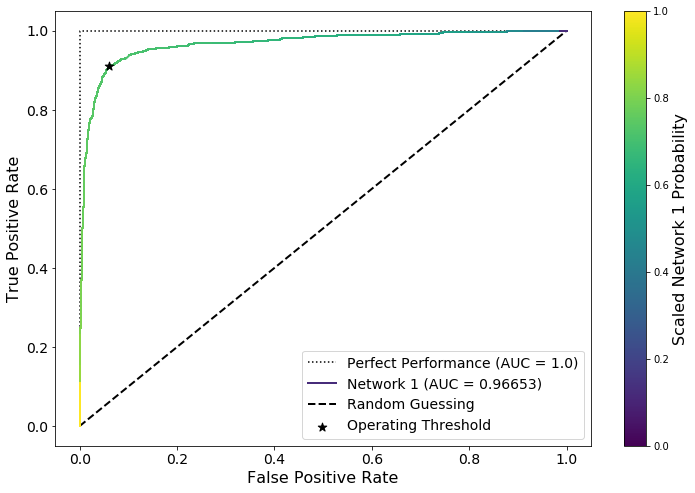

0.5027928


In [35]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve

precision, recall, f1_thresholds = precision_recall_curve(test_dataset_full[0:len(test_dataset_full)]['label'], validation_probs[:,1])
f1_scores = 2*recall*precision/(recall+precision)
operating_threshold = f1_thresholds[np.argmax(f1_scores)]

cm = plt.get_cmap('viridis')
lw = 2

plt.figure(figsize=(12,8))

fpr, tpr, thresholds = roc_curve(test_dataset_full[0:len(test_dataset_full)]['label'], validation_probs[:,1])

scaler = MinMaxScaler()
scaled_thresholds = scaler.fit_transform(np.where(thresholds < 0.3, 0.3, np.where(thresholds > 0.58, 0.58, thresholds)).reshape(-1,1)).reshape(len(thresholds),)

roc_auc = roc_auc_score(test_dataset_full[0:len(test_dataset_full)]['label'], validation_probs[:,1])
garb = plt.scatter(fpr + 80, tpr + 80, c=scaled_thresholds)
plt.plot([0.0,0.0,1.0], [0.0,1.0,1.0], label='Perfect Performance (AUC = 1.0)', ls=':', zorder=10, c='black')
for i in range(len(fpr) -1):
    if i > len(fpr) - 3:
        plt.plot([fpr[i], fpr[i+1]], [tpr[i], tpr[i+1]], c=cm(scaled_thresholds[i]), lw=2, zorder=20, label='Network 1 (AUC = %.5f)' %roc_auc)
    else:
        plt.plot([fpr[i], fpr[i+1]], [tpr[i], tpr[i+1]], c=cm(scaled_thresholds[i]), lw=2, zorder=20, label=None)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--', label='Random Guessing',c='black')
cbar = plt.colorbar(garb)
cbar.set_label('Scaled Network 1 Probability', size=16)
plt.scatter(fpr[np.argmin(np.abs(thresholds - operating_threshold))], tpr[np.argmin(np.abs(thresholds - operating_threshold))],marker='*', s=80, c='black', zorder=200, label='Operating Threshold')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)
plt.legend(loc="lower right", fontsize=14)
plt.show()
print(operating_threshold)

In [57]:
operating_threshold = 0.50003123

In [58]:
validation_probs = np.concatenate((validation_probs1, validation_probs2, validation_probs3))
md_test = pd.concat([md_test[0:1000],md_test[1000:2000],md_test[2000:3500]]).reset_index(drop=True)

validation_probs -= validation_probs.min()
validation_probs /= validation_probs.max()
validation_probs /= np.sum(validation_probs, axis=1)[:,np.newaxis]

pred_class0 = validation_probs[md_test.loc[md_test['ACTION'] == 'Good'].index]
pred_class1 = validation_probs[md_test.loc[md_test['ACTION'] == 'Marginal'].index]
pred_class3 = validation_probs[md_test.loc[md_test['ACTION'] == 'BadSubtraction'].index]
pred_class4 = validation_probs[(md_test.loc[md_test['ACTION'] == 'DarkSpotInTemplateCenter'].index) | 
                                         (md_test.loc[md_test['ACTION'] == 'NoisyTemplate'].index)]
pred_class6 = validation_probs[md_test.loc[md_test['ACTION'] == 'PsfInTemplate'].index]

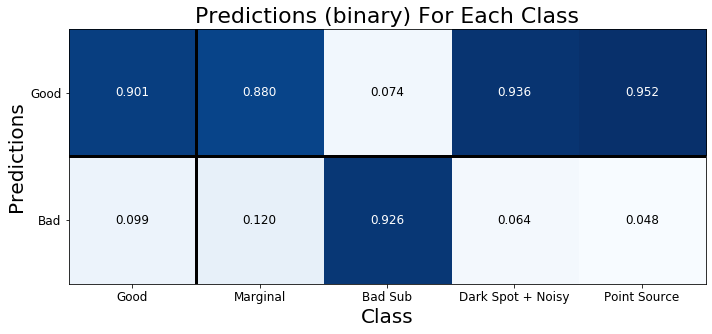

In [86]:
pred0_class0 = (pred_class0[:,1] < operating_threshold).sum()
pred1_class0 = (pred_class0[:,1] > operating_threshold).sum()

pred0_class0_per = pred0_class0/(pred0_class0 + pred1_class0)
pred1_class0_per = pred1_class0/(pred0_class0 + pred1_class0)

pred0_class1 = (pred_class1[:,1] < operating_threshold).sum()
pred1_class1 = (pred_class1[:,1] > operating_threshold).sum()

pred0_class1_per = pred0_class1/(pred0_class1 + pred1_class1)
pred1_class1_per = pred1_class1/(pred0_class1 + pred1_class1)

pred0_class3 = (pred_class3[:,1] < operating_threshold).sum()
pred1_class3 = (pred_class3[:,1] > operating_threshold).sum()

pred0_class3_per = pred0_class3/(pred0_class3 + pred1_class3)
pred1_class3_per = pred1_class3/(pred0_class3 + pred1_class3)

pred0_class4 = (pred_class4[:,1] < operating_threshold).sum()
pred1_class4 = (pred_class4[:,1] > operating_threshold).sum()

pred0_class4_per = pred0_class4/(pred0_class4 + pred1_class4)
pred1_class4_per = pred1_class4/(pred0_class4 + pred1_class4)

pred0_class6 = (pred_class6[:,1] < operating_threshold).sum()
pred1_class6 = (pred_class6[:,1] > operating_threshold).sum()

pred0_class6_per = pred0_class6/(pred0_class6 + pred1_class6)
pred1_class6_per = pred1_class6/(pred0_class6 + pred1_class6)

cm = np.array([[pred0_class0_per,pred0_class1_per,pred0_class3_per,pred0_class4_per,pred0_class6_per],
                [pred1_class0_per,pred1_class1_per,pred1_class3_per,pred1_class4_per,pred1_class6_per]])

classes = ['Good','Marginal','Bad Sub','Dark Spot + Noisy','Point Source']
labels = ['Good','Bad']

fig, ax = plt.subplots(1,1,figsize=(10, 8))

ax.imshow(cm, cmap=plt.cm.Blues)
ax.set_xlabel("Class", fontsize=20)
ax.set_ylabel("Predictions", fontsize=20)
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(classes, fontsize=12)
ax.set_yticklabels(labels, fontsize=12)
ax.axhline(0.5, linestyle='-', color='k', linewidth='3')
ax.axvline(0.5, linestyle='-', color='k', linewidth='3')

for i in range(len(labels)):
    for j in range(len(classes)):
        text = ax.text(j, i, format(cm[i, j],'.3f'),
                       ha="center", va="center", fontsize=12,
                       color="white" if cm[i, j] > 0.5 else "black")

ax.set_title('Predictions (binary) For Each Class', fontsize=22)
fig.tight_layout()

In [87]:
X_train0_sims, X_test0_sims, y_train0_sims, y_test0_sims, mdtrain0_sims, mdtest0_sims = TrainTest('good_simulated_images.h5','good_simulated_metadata.csv',1000,2000,0)

In [88]:
test_dataset_full_sims = ArtifactDataset(X_test0_sims, y_test0_sims, mdtest0_sims, transform=ToTensor())

In [89]:
validation_probs_sims = torch.max(cnn(test_dataset_full_sims[0:len(test_dataset_full_sims)]['image']), 1)[1].data.numpy()

In [90]:
passed_sims = mdtest0_sims.loc[mdtest0_sims['ACTION'] == 'Good'].reset_index().index[np.where(validation_probs_sims[mdtest0_sims.loc[mdtest0_sims['ACTION'] == 'Good'].reset_index().index] == 0)[0]]
passed_sims_mds = mdtest0_sims

In [91]:
hf1 = h5py.File('passed/Class_sims_images.h5', 'w')
hf1.create_dataset('passed_sims', data=X_test0_sims)
hf1.close()

In [92]:
mdtest0_sims.to_csv('passed/Class_sims_metadata.csv')

In [37]:
#torch.save(cnn.state_dict(), '/home/ashandonay/cosmology/model1.pt')

In [100]:
passed_good_index = md_test.loc[md_test['ACTION'] == 'Good'].index[np.where(validation_probs[md_test.loc[md_test['ACTION'] == 'Good'].index][:,1] < operating_threshold)[0]]

passed_good = X_test[passed_good_index]
passed_good_mds = md_test.loc[passed_good_index].reset_index(drop=True)

In [102]:
passed_marginal_index = md_test.loc[md_test['ACTION'] == 'Marginal'].index[np.where(validation_probs[md_test.loc[md_test['ACTION'] == 'Marginal'].index][:,1] < operating_threshold)[0]]

passed_marginal = X_test[passed_marginal_index]
passed_marginal_mds = md_test.loc[passed_marginal_index].reset_index(drop=True)

In [104]:
passed_badsub_index = md_test.loc[md_test['ACTION'] == 'BadSubtraction'].index[np.where(validation_probs[md_test.loc[md_test['ACTION'] == 'BadSubtraction'].index][:,1] < operating_threshold)[0]]

passed_badsub = X_test[passed_badsub_index]
passed_badsub_mds = md_test.loc[passed_badsub_index].reset_index(drop=True)

In [106]:
passed_noisy_index = md_test.loc[(md_test.loc[md_test['ACTION'] == 'DarkSpotInTemplateCenter'].index) | 
                                         (md_test.loc[md_test['ACTION'] == 'NoisyTemplate'].index)].index[np.where(validation_probs[(md_test.loc[md_test['ACTION'] == 'DarkSpotInTemplateCenter'].index) | 
                                         (md_test.loc[md_test['ACTION'] == 'NoisyTemplate'].index)][:,1] < operating_threshold)[0]]

passed_noisy = X_test[passed_noisy_index]
passed_noisy_mds = md_test.loc[passed_noisy_index].reset_index(drop=True)

In [108]:
passed_point_index = md_test.loc[md_test['ACTION'] == 'PsfInTemplate'].index[np.where(validation_probs[md_test.loc[md_test['ACTION'] == 'PsfInTemplate'].index][:,1] < operating_threshold)[0]]

passed_point = X_test[passed_point_index]
passed_point_mds = md_test.loc[passed_point_index].reset_index(drop=True)

In [110]:
hf1 = h5py.File('passed/Class_0_images.h5', 'w')
hf1.create_dataset('passed_good', data=passed_good)
hf1.close()

In [111]:
hf2 = h5py.File('passed/Class_1_images.h5', 'w')
hf2.create_dataset('passed_marginal', data=passed_marginal)
hf2.close()

In [112]:
hf3 = h5py.File('passed/Class_3_images.h5', 'w')
hf3.create_dataset('passed_badsub', data=passed_badsub)
hf3.close()

In [113]:
hf4 = h5py.File('passed/Class_4_images.h5', 'w')
hf4.create_dataset('passed_noisy', data=passed_noisy)
hf4.close()

In [114]:
hf6 = h5py.File('passed/Class_6_images.h5', 'w')
hf6.create_dataset('passed_point', data=passed_point)
hf6.close()

In [115]:
passed_good_mds.to_csv('passed/Class_0_metadata.csv')
passed_marginal_mds.to_csv('passed/Class_1_metadata.csv')
passed_badsub_mds.to_csv('passed/Class_3_metadata.csv')
passed_noisy_mds.to_csv('passed/Class_4_metadata.csv')
passed_point_mds.to_csv('passed/Class_6_metadata.csv')